In [1]:
import numpy as np
import pickle
import pprint
np.set_printoptions(suppress=True)
from shapely.geometry import (Polygon, LineString, MultiPoint)

from l5kit_conflict.pickle.io import *
from l5kit_conflict.process.preprocess import *
from l5kit_conflict.process.visualize import plot_scene_trajectories
from l5kit_conflict.filter.trajectory_filter import *
from l5kit_conflict.filter.conflict_filter import *

d:\github\lyft\l5kit\l5kit\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


In [3]:
dataset_name = "train2"
dataset = init_dataset(dataset_name)
scene_indices, frame_indices = load_pickle_v2(dataset_name)

In [4]:
scene_indices.sort()
# get all the scene tuples (2 or 3-element tuple)
scene_tuples = extract_intersection_scenarios(scene_indices=scene_indices)
print(f"#tuples in {dataset_name} dataset: {scene_tuples.__len__()}")
# # for now, only consider the 2-element tuple, or pair
# scene_pairs = []
# for t in scene_tuples:
#     if len(t) == 2:
#         scene_pairs.append(t)
# print(f"#pairs in {dataset_name} dataset: {scene_pairs.__len__()}")
# scene_tuples

#tuples in train2 dataset: 4940


In [12]:
# # define the study area of intersection 

# LEFT_TOP = (-850, -875)
# LEFT_BOTTOM = (-850, -925)
# RIGHT_TOP = (-700, -875)
# RIGHT_BOTTOM = (-700, -925)

# intersection_coords = (LEFT_TOP, LEFT_BOTTOM, RIGHT_BOTTOM, RIGHT_TOP, LEFT_TOP)
# intersection_area = Polygon(intersection_coords)
# intersection_area

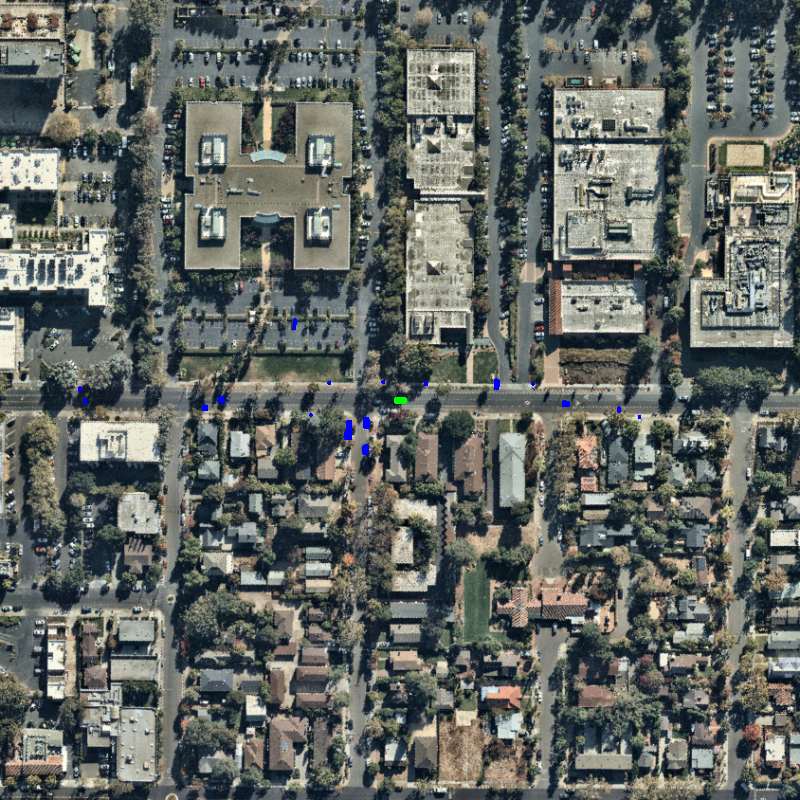

In [6]:
from IPython.display import display, clear_output
import PIL
from PIL import Image
import imageio
 
# cfg["raster_params"]["map_type"] = "py_satellite"
# rast = build_rasterizer(cfg, dm)
# dataset = EgoDataset(cfg, zarr_dataset, rast)

scene_idx = (93837, 93838, 93839)
indexes = []
for idx in scene_idx:
    indexes = indexes + list(dataset.get_scene_indices(idx))

images = []
for i, idx in enumerate(indexes):
    if i % 3 == 0:
        data = dataset[idx]
        im = data["image"].transpose(1, 2, 0)
        im = dataset.rasterizer.to_rgb(im)
        # target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
        # center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
        # draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
        clear_output(wait=True)
        display(Image.fromarray(im))
    
        pil_image = Image.fromarray(im)
        images.append(pil_image)

imageio.mimsave(f"./scene_gif/scene_train_1_{scene_idx[0]}.gif", images, duration=100)
clear_output(wait=True)

In [16]:
scene_tuple = scene_idx
delta_time = 50

ego_trajectory, agent_trajectories = get_process_trajectories(
    dataset=dataset,
    scene_indices=scene_tuple)

""" Ego trajectory filter """
# only focus on the study area
ego_trajectory_lineString = ego_trajectory.get_lineString()
ego_trajectory_intersection_lineString = ego_trajectory_lineString.intersection(intersection_area)
ego_trajectory_intersection_lineString = multiline_to_single_line(ego_trajectory_intersection_lineString)

# identify ego vehicle's behaviour (2 options: AV_left turning or AV_right turning):
is_AV_left_turn = is_AV_turnleft_or_right(ego_trajectory_intersection_lineString)

""" Agent trajectory filter """
HV_straight2right, HV_straight2left = [], []
HV_turnright_from_left, HV_turnright_from_bottom = [], []
HV_turnleft_from_right, HV_turnleft_from_bottom = [], []

# only focus on the study area
agent_trajectories = filter_scene_agent_trajectory(agent_trajectories, length_filter_threshold=20)

# identify agent vehicle's behaviour (6 behaviours)
agent_trajectories_intersection = {}
for agent_id, agent_traj in agent_trajectories.items():
    agent_trajectory_intersection_lineString = agent_traj.get_lineString().intersection(intersection_area)
    agent_trajectory_intersection_lineString = multiline_to_single_line(agent_trajectory_intersection_lineString)
    if agent_trajectory_intersection_lineString:
        agent_trajectory_intersection_lineString = multi2singleLineString(
            agent_trajectory_intersection_lineString)
        # whether HV goes straight towards right
        if is_HV_straight2right(agent_trajectory_intersection_lineString):
            HV_straight2right.append(agent_id)
        # whether HV goes straight towards left
        elif is_HV_straight2left(agent_trajectory_intersection_lineString):
            HV_straight2left.append(agent_id)
        # whether HV turns right from top-left arm of T-junction
        elif is_HV_turnright_from_left(agent_trajectory_intersection_lineString):
            HV_turnright_from_left.append(agent_id)
        # whether HV turns right from bottom-center arm of T-junction
        elif is_HV_turnright_from_bottom(agent_trajectory_intersection_lineString):
            HV_turnright_from_bottom.append(agent_id)
        # whether HV turns left from top-right arm of T-junction
        elif is_HV_turnleft_from_right(agent_trajectory_intersection_lineString):
            HV_turnleft_from_right.append(agent_id)
        # whether HV turns left from bottom-center arm of T-junction
        elif is_HV_turnleft_from_bottom(agent_trajectory_intersection_lineString):
            HV_turnleft_from_bottom.append(agent_id)

# %%
""" Identify the AV-HV conflicts """
if is_AV_left_turn:
    """ There are 3 cases in the AV left turning scenarios:
    1) HV goes straight -> AV-HV crossing
    2) HV turns right   -> AV-HV merging
    3) HV turns left    -> AV-HV crossing """
    if HV_straight2right:
        # Case #1: AV turns left + HV goes straight => crossing
        for agent_id in HV_straight2right:
            is_conflict, conflict = whether_line_conflict(
                traj_a=ego_trajectory, traj_b=agent_trajectories[agent_id], delta_time=delta_time)
            if is_conflict:
                print(scene_tuple, (-1, agent_id), "AV-left+HV-straight -> Crossing")
                AVHV_conflict["cross"]["straight&turnleft"].append({scene_tuple: conflict})

    if HV_turnright_from_left:
        # Case #2: AV turns left + HV turns right => merging
        for agent_id in HV_turnright_from_left:
            is_conflict, conflict = whether_buffer_conflict(
                traj_a=ego_trajectory, traj_b=agent_trajectories[agent_id],
                traj_a_side="right", traj_b_side="left", margin=1, delta_time=delta_time)
            if is_conflict:
                print(scene_tuple, (-1, agent_id), "AV-left+HV-right -> Merging")
                AVHV_conflict["merge"]["turnleft&turnright"].append({scene_tuple: conflict})

    if HV_turnleft_from_bottom:
        # Case #3: AV turns left + HV turns left => crossing
        for agent_id in HV_turnleft_from_bottom:
            is_conflict, conflict = whether_line_conflict(
                traj_a=ego_trajectory, traj_b=agent_trajectories[agent_id], delta_time=delta_time
            )
            if is_conflict:
                print(scene_tuple, (-1, agent_id), "AV-left+HV-left -> Crossing")
                AVHV_conflict["cross"]["turnleft&turnleft"].append({scene_tuple: conflict})

elif not is_AV_left_turn:
    """ There are 1 case in the AV right turning scenarios:
    Case #4: HV goes straight -> AV-HV merging """
    # Case #4: AV turns right + HV goes straight => merging
    if HV_straight2right:
        for agent_id in HV_straight2right:
            is_conflict, conflict = whether_buffer_conflict(
                traj_a=ego_trajectory, traj_b=agent_trajectories[agent_id],
                traj_a_side="left", traj_b_side="right", margin=1, delta_time=delta_time
            )
            print(is_conflict)
            if is_conflict:
                print(scene_tuple, (-1, agent_id), "AV-right+HV-straight -> Merging")
                AVHV_conflict["merge"]["straight&turnright"].append({scene_tuple: conflict})

# %%
""" Identify the HV-HV conflicts 
There are 6 cases of HV-HV conflicts """

# print(HV_turnleft_from_right, HV_straight2right)
# print(HV_turnleft_from_right, HV_turnleft_from_bottom)
# print(HV_turnleft_from_bottom, HV_straight2right)
# print(HV_turnleft_from_right, HV_turnright_from_left)
# print(HV_turnright_from_bottom, HV_straight2right)
# print(HV_turnleft_from_right, HV_straight2left)

# Case #1: HV turns left from top-right arm of T-junction +
# HV turns left from bottom-center arm of T-junction => crossing
if HV_turnleft_from_right and HV_turnleft_from_bottom:
    for agent1_id in HV_turnleft_from_right:
        for agent2_id in HV_turnleft_from_bottom:
            is_conflict, conflict = whether_line_conflict(
                traj_a=agent_trajectories[agent1_id], traj_b=agent_trajectories[agent2_id], delta_time=delta_time)
            if is_conflict:
                print(scene_tuple, (agent1_id, agent2_id), "HV-leftR+HV-leftB -> Crossing")
                HVHV_conflict["cross"]["turnleft&turnleft"].append({scene_tuple: conflict})

# Case #2: HV turns left from top-right arm of T-junction + HV goes straight => crossing
if HV_turnleft_from_right and HV_straight2right:
    for agent1_id in HV_turnleft_from_right:
        for agent2_id in HV_straight2right:
            is_conflict, conflict = whether_line_conflict(
                traj_a=agent_trajectories[agent1_id], traj_b=agent_trajectories[agent2_id], delta_time=delta_time)
            if is_conflict:
                print(scene_tuple, (agent1_id, agent2_id), "HV-leftR+HV-straight -> Crossing")
                HVHV_conflict["cross"]["straight&turnleftRight"].append({scene_tuple: conflict})

# Case #3: HV turns left from bottom-center arm of T-junction + HV goes straight => crossing
if HV_turnleft_from_bottom and HV_straight2right:
    for agent1_id in HV_turnleft_from_bottom:
        for agent2_id in HV_straight2right:
            is_conflict, conflict = whether_line_conflict(
                traj_a=agent_trajectories[agent1_id], traj_b=agent_trajectories[agent2_id], delta_time=delta_time)
            if is_conflict:
                print(scene_tuple, (agent1_id, agent2_id), "HV-leftB+HV-straight -> Crossing")
                HVHV_conflict["cross"]["straight&turnleftBottom"].append({scene_tuple: conflict})

# Case #4: HV turns right from top-left arm of T-junction +
# HV turns left from top-right arm of T-junction => merging
if HV_turnleft_from_right and HV_turnright_from_left:
    for agent1_id in HV_turnleft_from_right:
        for agent2_id in HV_turnright_from_left:
            is_conflict, conflict = whether_buffer_conflict(
                traj_a=agent_trajectories[agent1_id], traj_b=agent_trajectories[agent2_id],
                traj_a_side="right", traj_b_side="left", margin=1, delta_time=delta_time)
            if is_conflict:
                print(scene_tuple, (agent1_id, agent2_id), "HV-leftR+HV-rightL -> Merging")
                HVHV_conflict["merge"]["turnleft&turnright"].append({scene_tuple: conflict})

# Case #5: HV turns right from bottom-center arm of T-junction + HV goes straight to right => merging
if HV_turnright_from_bottom and HV_straight2right:
    for agent1_id in HV_turnright_from_bottom:
        for agent2_id in HV_straight2right:
            is_conflict, conflict = whether_buffer_conflict(
                traj_a=agent_trajectories[agent1_id], traj_b=agent_trajectories[agent2_id],
                traj_a_side="left", traj_b_side="right", margin=1, delta_time=delta_time)
            if is_conflict:
                print(scene_tuple, (agent1_id, agent2_id), "HV-rightB+HV-straight -> Merging")
                HVHV_conflict["merge"]["straight&turnright"].append({scene_tuple: conflict})

# Case #6: HV turns left from bottom-center arm of T-junction + HV goes straight to left => merging
if HV_turnleft_from_bottom and HV_straight2left:
    for agent1_id in HV_turnleft_from_bottom:
        for agent2_id in HV_straight2left:
            is_conflict, conflict = whether_buffer_conflict(
                traj_a=agent_trajectories[agent1_id], traj_b=agent_trajectories[agent2_id],
                traj_a_side="right", traj_b_side="left", margin=1, delta_time=delta_time)
            if is_conflict:
                print(scene_tuple, (agent1_id, agent2_id), "HV-leftB+HV-straight -> Merging")
                HVHV_conflict["merge"]["straight&turnleft"].append({scene_tuple: conflict})

(2199, 2200) (14, 16) HV-leftR+HV-straight -> Crossing


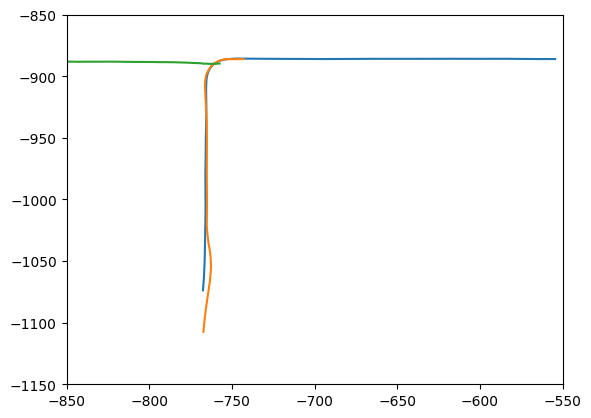

In [31]:
plot_scene_trajectories(ego_trajectory, {
    # 14: agent_trajectories[14], 
    16: agent_trajectories[16]
})